# 7 一般化線型混合モデル(GLMM)

実際のデータ解析でよく遭遇する「GLMではうまく説明できない」現象をうまく扱えるようにGLMを強化

一般化線型モデル(GLM)は確率分布・リンク関数・線型予測子を組み合わせて応答変数$y_i$と説明変数$x_i$を関連づけるシステム。
ただし、単純なGLMでは現実のデータ解析に応用できない。

例えば植物個体の種子数の調査を行うとする。説明変数がどの個体でも同じ値だったとする。
「観測された個体差」である説明変数に違いないのであれば、どの個体の種子数も同じ平均$\lambda$のポアソン分布に従うはず。
しかし、現実の生物では「説明変数以外は全部均質」といった条件は満たされないでしょうから、平均$\lambda$の値が全個体共通とはならない。

そのため、説明変数が同じであるなら平均も同じというGLMの過程が成立しないため、集団全体の種子数の分布はポアソン分布で期待されるよりも大きくばらつく。
「個体間の差異」が定量化できない。しかし「何か原因不明な個体差がある」ことは統計モデルとして表現できる。

「人間が測定できない・測定しなかった個体差」を組み込んだGLMのことを一般化線型混合モデル(generalized linser mixed model: GLMM)という。
データのばらつきは二項分布・ポアソン分布で、個体のばらつきは正規分布で表すような複数の確率分布を部品とする統計モデル。

## 7.1 例題: GLMでは説明できないカウントデータ

種子生存数の問題。
葉数とともにどのように増大するかを解明するのが目的。

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# ダークモードの場合、設定しないとメモリが見えなくなる
plt.style.use('dark_background')

import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
from scipy.stats import poisson,binom
import math

# https://github.com/aviatesk/intro-statistical-modeling/edit/master/data/data7.csv
data7 = pd.read_csv('../data/data7.csv')
data7.describe()


,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


<AxesSubplot:xlabel='x', ylabel='y'>

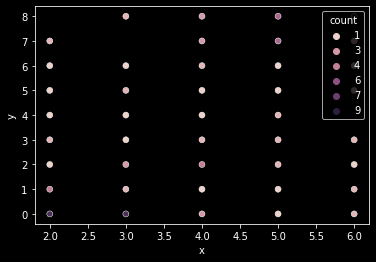

In [14]:
data7_grouped = data7.drop(["N", "id"], axis=1).groupby(['x', 'y']).size().to_frame('count').reset_index()
sns.scatterplot(x='x', y='y', hue="count", data=data7_grouped)

GLMを使ってデータから種子の生存確率を推定してみる。
線型予測子とロジットリンク関数を使って、生存確率を$q_i$とすると

$logit(q_i) = \beta_1 + \beta_2 x_i$

とする。観測された生存種子数が$y_i$である確率が二項分布に従うとすると

$p(y_i| \beta_1, \beta_2) = \begin{pmatrix} 8 \\ y_i \end{pmatrix} q_i^{y_i}(1-q_i)^{8-y_i}$

となる。全個体の対数尤度は

$logL=\sum_i log p(y_i|\beta_1,\beta_2)$

となる。このlogLが最大となる切片$\beta_1, \beta_2$をみつけるのがこの統計の最尤推定。

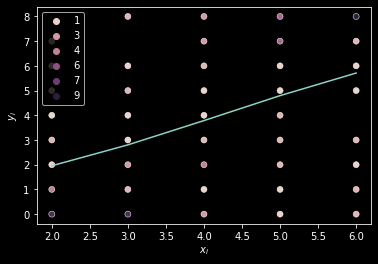

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Wed, 06 Jan 2021   Deviance:                       513.84
Time:                        16:44:57   Pearson chi2:                     428.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000      -2.614      -1.684
x              0.5104      0.056      9.179      0.000       0.401       0.619
==============================================================================
"""

In [18]:
import statsmodels.api as sm
fit = smf.glm(formula='y + I(N - y) ~ x', data=data7, family=sm.families.Binomial())
res_fit = fit.fit()
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(x='x', y='y', hue="count", data=data7_grouped)
x_list = np.arange(2, 7, 1)
y_list = res_fit.predict(exog = pd.DataFrame({'x': x_list}))
# y_listは生存確率なのでNの8をかける
ax.plot(x_list, y_list * 8)
ax.set_xlabel('$x_i$')
ax.set_ylabel('$y_i$')
ax.legend()
plt.show()

res_fit.summary()

$\hat{\beta_1}=-2.14, \hat{\beta_2}=0.51$となっている。

だが、真の傾きは$\beta_2=1$らしい。
ここでつくったものは二項分布に従っている感じではないっぽい

## 7.2 過分散と個体差

N個の種子のうちy個が生存したというカウントデータを使っているのにそのばらつきが二項分布で説明できないように見える。
にもかかわらずむりやり二項分布であると仮定したモデルを無理やりに当て嵌めたので正しい推定値が得られなかった。
このように二項分布で期待されるよりも大きなばらつきを過分散(over dispersion)という

### 7.2.1 過分散: ばらつきが多すぎる

葉数$x_i=4$の個体の生存種子数のデータがどのように「二項分布にあっていないのか」を調べます。

In [27]:
four_leaf = data7[data7['x'] == 4]
four_leaf_grouped = four_leaf.drop(["N", "id"], axis=1).groupby(['x', 'y']).size().to_frame('count').reset_index()
print(four_leaf_grouped)
print('平均: ', four_leaf['y'].mean())
print('分散: ', four_leaf['y'].var())

   x  y  count
0  4  0      3
1  4  1      1
2  4  2      4
3  4  3      2
4  4  4      1
5  4  5      1
6  4  6      2
7  4  7      3
8  4  8      3
平均:  4.05
分散:  8.365789473684211


生存種子数が二項分布に従うのであれば、分散が8x0.5x(1-0.5)=2くらいになるはず。(これめっちゃ大事そう)
しかし実際右派8.37なので、過分散。
よって二項分布を使って説明できないということ

### 7.2.2 観測されていない個体差がもたらす過分散

他にも二項分布のズレの原因として、観測されていない個体差がある可能性がある。

例：
観測データ上ではどれも同じに見える植物個体たちの種子数を調べたところ、全体の半数の個体で生存種子数がゼロ、残り半数で全種子が生存が観測された状況。
種子の生存確率の集団平均は

全体生存数/前調査種子数

と定義され、0.5となる。

各個体の調査種子数は8なので、平均生存種子数は4となる。しかし、生存種子数4の個体はひとつもいない。
標本分散は8x4^2/8=16。
二項分布から期待される分散はNq(1-q) = 8x0.5x0.5=2なので、これも過分散であることがわかる。
これでは観察された現象のパターンを説明できない。

そもそも過分散とは統計モデリングしている人間の錯誤を表している。
この個体たちはみんな均質と過度に単純化した仮定を設けて、全個体の生存種子数の分布はただ一つの二項分布で説明できると期待していたのに失敗してしまったことを過分散と呼ぶ。

### 7.2.3 観測されていない個体差とは何か？

種子の話で言うと、土、日光の当たり具合、植木鉢の位置などの定量・特定することが不可能なものを個体差、場所差という。
個体差や場所差を原因不明のままうまく取り込んだ統計モデルが必要。

## 7.3 一般化線型混合モデル

一般化線型混合モデル(GLMM)は個体差や場所さの効果をGLMに組み込んだ統計モデル。
今回はロジスティック回帰のGLMMを説明。

### 7.3.1 個体差を表すパラメータの追加

架空植物の種子の生存確率$q_i$を表す式に、個体iの個体差を表すパラメータ$r_i$を追加

$logit(q_i)=\beta_1 + \beta_2 x_i + r_i$

この$r_i$は$-\infty$から$\infty$までの範囲を取る連続値と考える。
「観測されていない個体差などない」と仮定しているGLMは、種子数を調査した全個体で$r_i=0$と設定していることになる。
当たり前だが$r_i$の値の大小が生存確率$q_i$に大きく影響を与える。

## 7.3.2 個体差のばらつきを表す確率分布

GLMMでは$\{r_1, r_2, ...,r_{100}\}$が何か確率分布に従っていると仮定する。
つまり個体差のばらつきを確率分布で表すことができて、しかもデータに基づいてその確率分布のパラメータを推定できると考えている。
ただし、切片$\beta_1$や傾き$\beta_2$は特に確率分布に従うと考えていない。

いったん、仮定として個体差$r_i$は平均0で標準偏差sの正規分布に従うとする。
$r_i$の分布が正規分布である根拠は何もなく、そもそも観測できない・観測しなかった量なのでどのような確率分布に従うのかわからない。
正規分布を使うのは、、統計モデリングに便利だからなだけ。
単純化のため、$r_i$は個体感で相互に独立した確率変数であると仮定する。

上記前提を受け入れると確率密度函数$p(r_i|s)$は以下のようになる

$p(r_i|s)=\frac{1}{\sqrt{2\pi s^2}} exp(- \frac{r^2_i}{2s^2})$

この確率密度$p(r_i|s)$は$r_i$の「出現しやすさ」を表している。

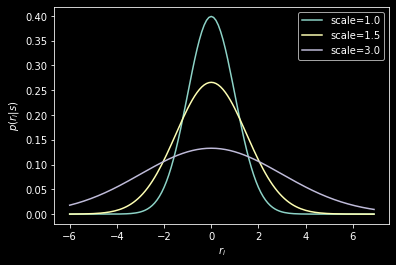

In [12]:
#https://www.python.ambitious-engineer.com/archives/2174
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
x_list = np.arange(-6, 7, 0.1)

# 平均
average = 0
# 標準偏差
scale_list=[1.0, 1.5, 3.0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$r_i$')
ax.set_ylabel('$p(r_i|s)$')
for scale in scale_list:
    y_list = norm.pdf(x_list, loc=average, scale=scale)
    ax.plot(x_list, y_list, label="scale={}".format(scale))
    ax.legend()
plt.show()

上記図を見ればわかるように0付近で$p(r_i|s)$が高くなっている。$r_i$がゼロに近い個体は割とありがち(そりゃ平均がゼロだからでしょ。。。)で、
$r_i$の絶対値が大きな個体は相対的にあまりいないことを表現している。
標準偏差sは「集団内の$r_i$のばらつき」を表している。
当たり前だが下記のことが言える。

- sが小さければ個体差の小さい、均等な集団
- sが大きければ過分散がひどい

## 7.3.3 線型予測子の構成要素: 固定効果とランダム効果

Q. 一般化線型混合モデルの混合とは何か？

A. 統計モデルに線型予測子が含まれている場合、構成要素は固定効果(fixed effects)とランダム効果(random effects)に分類されてきた。
線型予測子に固定効果とランダム効果の表す項を持っているのでそのようなGLMは混合モデルと呼ばれている。

データのばらつきが正規分布で「リンク関数なし」つまり恒等リンク関数と指定した場合、すなわち「一般化」でない線型モデルでは、
固定効果は全体の平均を変え、ランダム効果は平均は変化しないが、全体のばらつきを変えると説明されていた。

$logit(q_i)=\beta_1 + \beta_2 x_i + r_i$では、$\beta_1 , \beta_2 x_i $は固定効果、$r_i$はランダム効果。

## 7.4 一般化線型混合モデルの最尤推定